## Feature selection: Model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel

import os
#os.environ["PATH"] += os.pathsep + 'C:\\Users\\jander33\\Desktop\\project_5\\programs\\graphviz\\bin'


import sys
sys.path.append('../code/quickpipeline')
sys.path.append('../code/cleaners')
sys.path.append('../code/features')
#sys.path.append(r'C:\\Users\\jander33\\Desktop\\project_5\\programs')
#sys.path.append(r'C:\Miniconda3\envs\tf\Lib\site-packages')

#print(sys.path)
from quickpipeline import QuickPipeline
from J_cleaner import *
from j_features import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
cat_df = pd.read_csv('../data/processed3/cat_df.csv')
num_df = pd.read_csv('../data/processed3/num_df.csv')
text_df = pd.read_csv('../data/processed3/text_df.csv')
res_out = pd.read_csv('../data/processed3/outliers_response.csv')


In [4]:
data = pd.concat([num_df, cat_df, text_df, res_out], axis=1)
data.shape

(28105, 113)

In [5]:
X = data[data['outliers'] == 1]
X.drop(['outliers'], axis=1, inplace=True)
X.reset_index(level=0, drop=True, inplace=True)
X.shape

/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(26699, 112)

In [6]:
y = X[['TRV.Win']]
y2 =  X[['Competitor.Premium']]
X.drop(['TRV.Win', 'Competitor.Premium'], axis=1, inplace=True)
y['TRV.Win'].value_counts()

/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    18671
1     8028
Name: TRV.Win, dtype: int64

### Feature selection with XG BOOST

In [7]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree, to_graphviz

In [8]:
# pipeline = QuickPipeline(categorical_features=None) 
# X = pipeline.fit_transform(df) 
y_ = np.ravel(y)

model = XGBClassifier(max_depth=5,
                      min_child_weight=20,
                      colsample_bytree=0.7,
                      gamma=0.1,
                      reg_alpha=0.1,
                      reg_lambda=0.1,
                      max_delta_step=1)
model.fit(X, y_)


scores = cross_val_score(model, X, y_, cv=5)
print(scores)  


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

[0.77045497 0.76722846 0.77097378 0.76474995 0.76362615]


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
# Print the feature ranking

print("Feature ranking:")

for i in range(0, len(indices)):
    print('{}. Feature: {}  with weight: {}'.format(i + 1, X.columns[indices[i]], importances[indices[i]]))


Feature ranking:
1. Feature: TRV.Price  with weight: 0.13703176379203796
2. Feature: tot_bld_annl_rev_amt  with weight: 0.05547652766108513
3. Feature: fnl_prc_pt_fct  with weight: 0.053579896688461304
4. Feature: merge_freq  with weight: 0.044570885598659515
5. Feature: w2v  with weight: 0.04314841330051422
6. Feature: program_freq  with weight: 0.03745851293206215
7. Feature: prcnt_blg_tiv  with weight: 0.03413940221071243
8. Feature: terr_pctl_bldgfire  with weight: 0.030820293352007866
9. Feature: comp_freq  with weight: 0.029871977865695953
10. Feature: terr_pctl_liab  with weight: 0.02892366051673889


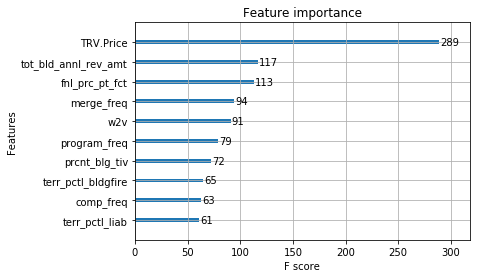

In [10]:
# plot feature importance
plot_importance(model, max_num_features=10)
plt.show()


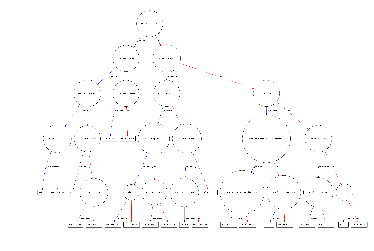

In [13]:
plot_tree(model, num_trees=0, rankdir='UT', ax=None)

In [ ]:
to_graphviz(model, num_trees=0, rankdir='UT', yes_color='#0000FF', no_color='#FF0000')

### using threshold -> col names disappear

In [12]:
model_re = SelectFromModel(model, threshold='.5*mean', prefit=True)
X_re = model_re.transform(X)
df = pd.DataFrame(X_re)
df.shape   

(26699, 44)

In [24]:
final_features = pd.concat([df, y], axis=1)

In [25]:
#to models, no column names
final_features.to_csv(r'C:\Users\jander33\Desktop\projects\project5\models\data_incoming\7_17_df_model.csv', index=False)

### Taking top 60 features and keeping col names

In [11]:
# manually select features IOT preserve column names
indices = np.argsort(importances)[::-1][:60]
feat_top = X.columns[indices][0:60]
df_manual = X[feat_top]

In [12]:
# competitor premium included for NID
final_features = pd.concat([df_manual, y2, y], axis=1)

In [14]:
#to models, with column names
final_features.to_csv('../data/processed4/7_27_df_model.csv', index=False)

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
clf = tree.DecisionTreeClassifier(max_depth=5) 
clf = clf.fit(X, np.ravel(y))


In [17]:
dot_data = tree.export_graphviz(clf, out_file=None,  feature_names=X.columns,  
class_names=None,  filled=True, rounded=True, special_characters=True) 


graph = graphviz.Source(dot_data)  

graph.render('img/dtree_render_final',view=True)

'img/dtree_render_final.pdf'